<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
from sklearn.datasets import make_regression, make_classification, load_iris, load_wine
from sklearn.model_selection import train_test_split

In [2]:
#X, y = make_classification(1000, 12, n_informative = 9, n_classes = 3, n_clusters_per_class = 2)
X, y = load_wine(return_X_y = True)

In [3]:
class Node():
    
    def __init__(self, feature, value, kind, l_answer = None, r_answer = None):
        self.feature = feature
        self.value = value
        self.kind = kind
        self.l_answer = l_answer
        self.r_answer = r_answer
    
    def split(self, left_node, right_node):
        self.left_node = left_node
        self.right_node = right_node
        if not isinstance(self.left_node, Node):
            self.l_answer = self.left_node
        if not isinstance(self.right_node, Node):
            self.r_answer = self.right_node

In [4]:
class DecisionTreeClassifier():

    def __init__(self, max_depth = 6, criterion = 'gini', min_samples_leaf = 2):
        self.max_depth = max_depth
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.root_node = None

    def fit(self, X, y):
        tree = self.grow_tree(X, y, current_depth = 0)

    def predict(self, X):
        num_samples = X.shape[0]
        preds = np.empty(num_samples, dtype = np.int64)
        for sample in range(num_samples):
            preds[sample] = self.forward(X[sample])
        return preds

    def grow_tree(self, X, y, current_depth):
        
        split = self.get_best_splits(X, y)
        if not isinstance(split, list):
            return split
        current_node = Node(split[0], split[1], split[2])
        if self.root_node is None:
            self.root_node = current_node
            
        print(current_depth)
        current_depth = current_depth + 1
                                      
        if isinstance(split, list):
    
            if current_depth > self.max_depth:
                return np.unique(y)[np.argmax(np.unique(y, return_counts = True)[1])]
    
            if split[2] == 'cat':
                X_left = X[X[:, split[0]] == split[1]]
                X_right = X[X[:, split[0]] != split[1]]
                y_left = y[X[:, split[0]] == split[1]]
                y_right = y[X[:, split[0]] != split[1]]
                #left_tree = self.grow_tree(X_left, y_left, current_depth)
                #right_tree = self.grow_tree(X_right, y_right, current_depth)
                current_node.split(self.grow_tree(X_left, y_left, current_depth), self.grow_tree(X_right, y_right, current_depth))
            elif split[2] == 'num':
                X_left = X[X[:, split[0]] < split[1]]
                X_right = X[X[:, split[0]] >= split[1]]
                y_left = y[X[:, split[0]] < split[1]]
                y_right = y[X[:, split[0]] >= split[1]]
                #left_tree = self.grow_tree(X_left, y_left, current_depth)
                #right_tree = self.grow_tree(X_right, y_right, current_depth)
                current_node.split(self.grow_tree(X_left, y_left, current_depth), self.grow_tree(X_right, y_right, current_depth))
            else:
                raise ValueError
        return current_node

    def get_best_splits(self, X, y):
        best_split = ['', '', '']
        best_information_gain = 0
        for i in range(X.shape[1]):
            if len(np.unique(X[:, i])) < 10:
                for val in np.unique(X[:, i]):
                    y_left = y[X[:, i] == val]
                    y_right = y[X[:, i] != val]
                    information_gain = self.calc_information_gain(y, y_left, y_right)
                    if information_gain > best_information_gain:
                        best_information_gain = information_gain
                        best_split[0] = i
                        best_split[1] = val
                        best_split[2] = 'cat'
            else:
                for val in np.unique(X[:, i]):
                    y_left = y[X[:, i] < val]
                    y_right = y[X[:, i] >= val]
                    information_gain = self.calc_information_gain(y, y_left, y_right)
                    if information_gain > best_information_gain:
                        best_information_gain = information_gain
                        best_split[0] = i
                        best_split[1] = val
                        best_split[2] = 'num'
        if best_split[0] == '' or best_split[1] == '' or best_split[2] == '':
            return np.unique(y)[0]
        return best_split
        
    def calc_information_gain(self, y, y1, y2):
        criterion = self.criterion
        if criterion == 'gini':
            information_gain = self.gini(y) - (len(y1) / len(y) * self.gini(y1) + len(y2) / len(y) * self.gini(y2))
        elif criterion == 'entropy':
            information_gain = self.entropy(y) - (len(y1) / len(y) * self.entropy(y1) + len(y2) / len(y) * self.entropy(y2))
        else:
            raise AttributeError()
        return information_gain

    def entropy(self, y):
        entropy_ = 0
        for i, yi in enumerate(np.unique(y, return_counts = True)[0]):
            prob = np.unique(y, return_counts = True)[1][i] / y.shape[0]
            entropy_+= prob * np.log2(prob)
        return -entropy_

    def gini(self, y):
        gini_ = 0
        for i, yi in enumerate(np.unique(y, return_counts = True)[0]):
            prob = np.unique(y, return_counts = True)[1][i] / y.shape[0]
            gini_+= 1 - (prob**2)
        return gini_
    
    def forward(self, X):
        answer = None
        node = self.root_node
        while answer is None:
            feature = node.feature
            value = node.value
            kind = node.kind
            if X[feature] < value:
                if node.l_answer is not None:
                    return node.l_answer
                node = node.left_node
            else:
                if node.r_answer is not None:
                    return node.r_answer
                node = node.right_node



In [25]:
dt = DecisionTreeClassifier(max_depth = 6, criterion = 'entropy')

In [26]:
dt.fit(X, y)

0
1
2
1
2
3
2


In [27]:
preds = dt.predict(X)

In [8]:
from sklearn.metrics import f1_score, accuracy_score

In [28]:
f1_score(y, preds, average = 'weighted')

0.9943776572990056

In [29]:
accuracy_score(y, preds)

0.9943820224719101

In [43]:
X[43][0]

13.24

In [48]:
dt.root_node.right_node.left_node.right_node.right_node

1

In [10]:
from sklearn.decomposition import PCA
pca = PCA(2)
X_ = pca.fit_transform(X)

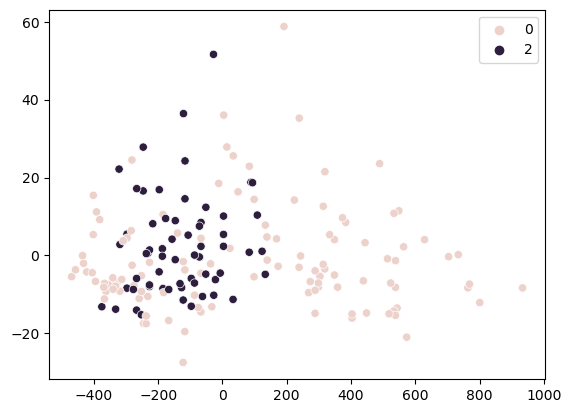

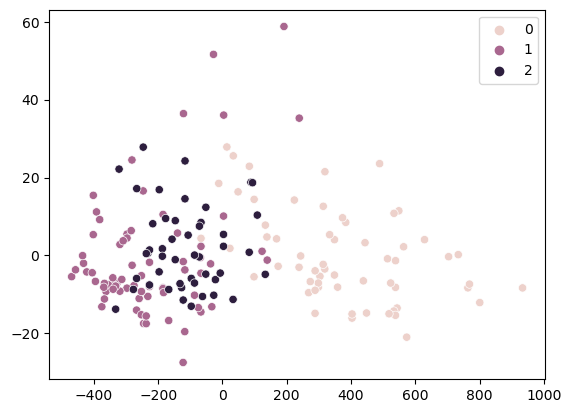

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.scatterplot(x = X_[:, 0], y = X_[:, 1], hue = preds)
plt.show()
sns.scatterplot(x = X_[:, 0], y = X_[:, 1], hue = y)
plt.show()

In [53]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc = DTC(max_depth = 6)
dtc.fit(X, y)
preds_sk = dtc.predict(X)
print(f1_score(y, preds_sk, average = 'weighted'))
print(accuracy_score(y, preds_sk))

1.0
1.0


In [57]:
dt.root_node.value

1.58

[Text(0.5657894736842105, 0.9166666666666666, 'x[12] <= 755.0\ngini = 0.658\nsamples = 178\nvalue = [59, 71, 48]'),
 Text(0.34210526315789475, 0.75, 'x[11] <= 2.115\ngini = 0.492\nsamples = 111\nvalue = [2, 67, 42]'),
 Text(0.21052631578947367, 0.5833333333333334, 'x[10] <= 0.935\ngini = 0.227\nsamples = 46\nvalue = [0, 6, 40]'),
 Text(0.10526315789473684, 0.4166666666666667, 'x[6] <= 1.58\ngini = 0.049\nsamples = 40\nvalue = [0, 1, 39]'),
 Text(0.05263157894736842, 0.25, 'gini = 0.0\nsamples = 39\nvalue = [0, 0, 39]'),
 Text(0.15789473684210525, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.3157894736842105, 0.4166666666666667, 'x[6] <= 0.565\ngini = 0.278\nsamples = 6\nvalue = [0, 5, 1]'),
 Text(0.2631578947368421, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.3684210526315789, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(0.47368421052631576, 0.5833333333333334, 'x[6] <= 0.795\ngini = 0.117\nsamples = 65\nvalue = [2, 61, 2]'),
 Text(0.42105

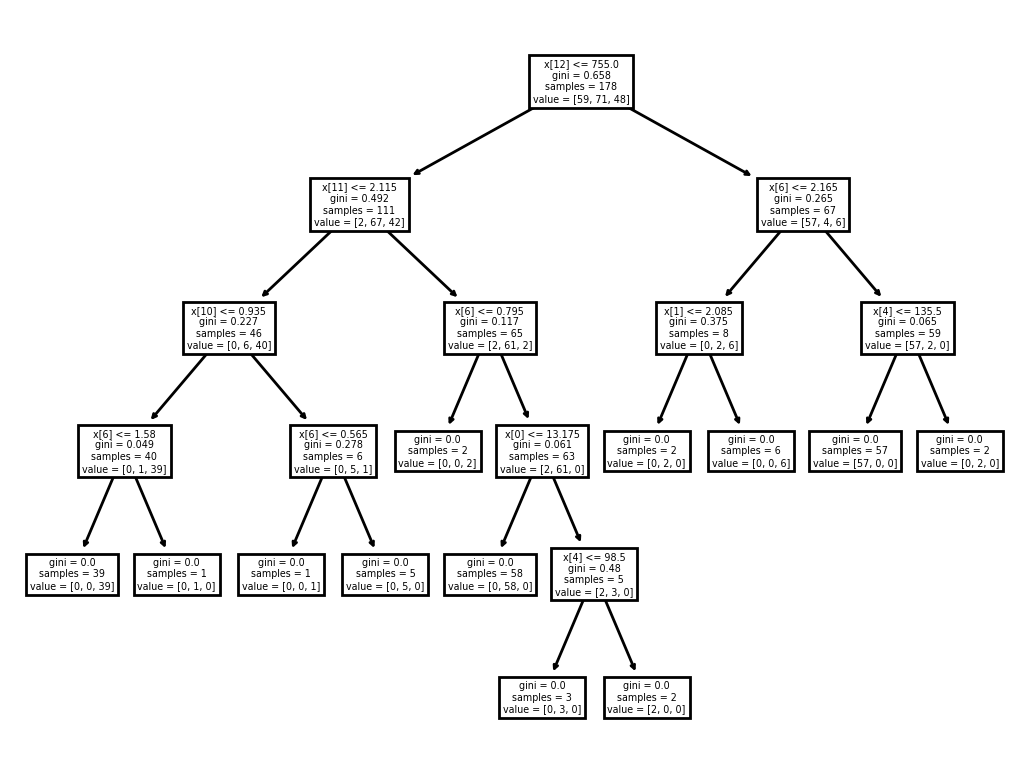

In [56]:
from sklearn.tree import plot_tree
fig = plt.figure(dpi = 200)
plot_tree(dtc)